# 01 - EDA and Experimentation

This notebook details the EDA and experimentation process with model building.

In [ ]:
import os
import time
import matplotlib.pyplot as plt
import gc; gc.enable() # memory is tight
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

from tensorflow import keras
from skimage.segmentation import mark_boundaries
from skimage.util import montage as montage2d
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage

from typing import List
from google.cloud import bigquery, storage
from google.cloud import aiplatform as vertex_ai
from src.utils.dataset import *
from src.utils.common import *

from google_cloud_pipeline_components.experimental.custom_job import utils
from kfp.v2 import compiler, dsl
from kfp.v2.dsl import component

## Config

In [3]:
PROJECT = 'mle-airbus-detection-smu' # Change to your project id.
REGION = 'asia-east1' # Change to your region.
BUCKET = 'mle_airbus_dataset' # Change to your bucket name.
SERVICE_ACCOUNT = "service-account-for-mle@mle-airbus-detection-smu.iam.gserviceaccount.com"

if PROJECT == "" or PROJECT is None or PROJECT == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT = shell_output[0]
    
if SERVICE_ACCOUNT == "" or SERVICE_ACCOUNT is None or SERVICE_ACCOUNT == "[your-service-account]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.account)' 2>/dev/null
    SERVICE_ACCOUNT = shell_output[0]
    
if BUCKET == "" or BUCKET is None or BUCKET == "[your-bucket-name]":
    # Get your bucket name to GCP projet id
    BUCKET = PROJECT
    # Try to create the bucket if it doesn'exists
    ! gsutil mb -l $REGION gs://$BUCKET
    print("")
    
!gcloud config set project {PROJECT}

Updated property [core/project].


## Database Config

In [4]:
PIPELINE_NAME = 'airbusmlepipeline'
BQ_DATASET_NAME = 'mle-airbus-detection-smu.airbus_data' # Change to your BQ dataset name.
BQ_TABLE_NAME = 'label_data'
BQ_LOCATION = 'asia-east1'

In [5]:
PARENT = f"projects/{PROJECT}/locations/{REGION}"

# Path to various pipeline artifact.
PIPELINE_ROOT = 'gs://{}/{}/pipeline_root'.format(
    BUCKET, PIPELINE_NAME)

# Paths for users' Python module.
MODULE_ROOT = 'gs://{}/{}/pipeline_module'.format(
    BUCKET, PIPELINE_NAME)

# Paths for users' data.
DATA_ROOT = 'gs://{}/{}/data'.format(BUCKET, PIPELINE_NAME)

# This is the path where your model will be pushed for serving.
SERVING_MODEL_DIR = 'gs://{}/{}/serving_model'.format(
    BUCKET, PIPELINE_NAME)

print('PIPELINE_ROOT: {}'.format(PIPELINE_ROOT))
print('MODULE_ROOT: {}'.format(MODULE_ROOT))
print('DATA_ROOT: {}'.format(DATA_ROOT))
print('SERVING_MODEL_DIR: {}'.format(SERVING_MODEL_DIR))
print("Project ID:", PROJECT)
print("Region:", REGION)
print("Bucket name:", BUCKET)
print("Service Account:", SERVICE_ACCOUNT)
print("Vertex API Parent URI:", PARENT)

storage_client = storage.Client(project=PROJECT)
bucket = storage_client.get_bucket(BUCKET)
storage_path = f"gs://{BUCKET}/train_v2/"
print (f"Image storage path:{storage_path}")

VERSION = 'v01'
DATASET_DISPLAY_NAME = 'airbus-ship-dataset-display'
MODEL_DISPLAY_NAME = f'{DATASET_DISPLAY_NAME}-classifier-{VERSION}'

WORKSPACE = f'gs://{BUCKET}/{DATASET_DISPLAY_NAME}'
EXPERIMENT_ARTIFACTS_DIR = os.path.join(WORKSPACE, 'experiments')

TENSORBOARD_DISPLAY_NAME = f'tb-{DATASET_DISPLAY_NAME}'
EXPERIMENT_NAME = f'{MODEL_DISPLAY_NAME}'

PIPELINE_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/pipeline_root
MODULE_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/pipeline_module
DATA_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/data
SERVING_MODEL_DIR: gs://mle_airbus_dataset/airbusmlepipeline/serving_model
Project ID: mle-airbus-detection-smu
Region: asia-east1
Bucket name: mle_airbus_dataset
Service Account: service-account-for-mle@mle-airbus-detection-smu.iam.gserviceaccount.com
Vertex API Parent URI: projects/mle-airbus-detection-smu/locations/asia-east1
Image storage path:gs://mle_airbus_dataset/train_v2/


## Set correct IAM permission rights for google cloud storage

In [6]:
! gsutil ls -al "gs://"$BUCKET

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator "gs://"$BUCKET

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer "gs://"$BUCKET

      2373  2022-06-26T04:02:36Z  gs://mle_airbus_dataset/mle-airbus-detection-smu-b1f8ee58e814.json#1656216156596465  metageneration=1
    204668  2022-06-28T10:45:30Z  gs://mle_airbus_dataset/test.parquet#1656413130677179  metageneration=1
   1521803  2022-06-28T10:45:30Z  gs://mle_airbus_dataset/train.parquet#1656413130620390  metageneration=1
 419430400  2022-06-28T07:50:55Z  gs://mle_airbus_dataset/train_hist.csv#1656402655219285  metageneration=1
        21  2022-06-28T07:50:55Z  gs://mle_airbus_dataset/train_threshold.txt#1656402655286135  metageneration=1
                                 gs://mle_airbus_dataset/airbusmlepipeline/
                                 gs://mle_airbus_dataset/pipeline_root/
                                 gs://mle_airbus_dataset/train_v2/
                                 gs://mle_airbus_dataset/trained_model/
TOTAL: 5 objects, 421159265 bytes (401.65 MiB)


No changes made to gs://mle_airbus_dataset/


## Model Training Params

In [46]:
N_TRUNCATE = 20000
BATCH_SIZE = 16
EDGE_CROP = 0
NB_EPOCHS = 10
N_REPEAT=1
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 10
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False
N_SAMPLE = 100
IMG_SHAPE = (128, 128)

# Setup Infra on GCP

In [47]:
import json
import os
import sys

import numpy as np
from google.cloud import aiplatform, bigquery
from google.cloud.aiplatform import gapic as aip

aiplatform.init(project=PROJECT, location=REGION, staging_bucket=BUCKET)

In [48]:
TRAIN_GPU, TRAIN_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_K80, 1)

DEPLOY_GPU, DEPLOY_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_K80, 1)

TRAIN_VERSION = "tf-gpu.2-8"
DEPLOY_VERSION = "tf2-gpu.2-8"

TRAIN_IMAGE = "us-docker.pkg.dev/vertex-ai/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(DEPLOY_VERSION)

print("Training:", TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

Training: us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-8:latest AcceleratorType.NVIDIA_TESLA_K80 1
Deployment: us-docker.pkg.dev/vertex-ai/prediction/tf2-gpu.2-8:latest AcceleratorType.NVIDIA_TESLA_K80 1
Train machine type n1-standard-4
Deploy machine type n1-standard-4


## Start EDA process

In [49]:
BQ_DATASET_NAME = 'mle-airbus-detection-smu.airbus_data' # Change to your BQ dataset name.
BQ_TABLE_NAME = 'label_data'

In [50]:
bqclient = bigquery.Client()

# Download a table.
table = bigquery.TableReference.from_string(
    f"{BQ_DATASET_NAME}.{BQ_TABLE_NAME}"
)
rows = bqclient.list_rows(
    table
)
df_train = rows.to_dataframe(
    # Optionally, explicitly request to use the BigQuery Storage API. As of
    # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
    # API is used by default.
    create_bqstorage_client=True,
)

## Explore decoding and encoding of Run-Length-Encoding

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


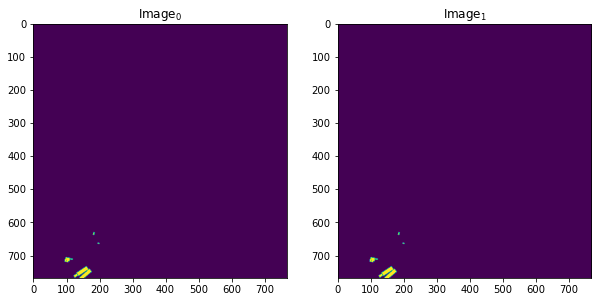

In [51]:
masks = df_train
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels'].values
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

## Truncate Data Size 

In [52]:
masks = masks[:N_TRUNCATE]
masks

ImageId                                      EncodedPixels
0      000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
1      000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
2      000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
3      000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
4      000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...              ...                                                ...
19995  3f8219477.jpg  114050 3 114818 9 115586 14 116353 21 117121 2...
19996  3f823ec02.jpg  95399 1 96166 3 96933 5 97702 4 98471 4 99239 ...
19997  3f837652a.jpg  286169 2 286937 6 287704 11 288472 14 289239 1...
19998  3f854d9f1.jpg  391829 6 392592 11 393360 11 394128 11 394897 ...
19999  3f86bba8d.jpg  152695 5 153463 10 154231 10 154999 10 155767 ...

[20000 rows x 2 columns]

## Merge multiple RLE into single row and preprocessing

In [53]:
masks.replace(to_replace=[None], value='', inplace=True)
masks = masks.groupby(['ImageId'])['EncodedPixels'].apply(lambda x: ';'.join(x) if x is not None else ';'.join('')).reset_index()

C:\Users\songh\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\frame.py:4521: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: c_row.count(";"))
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
masks.drop(['ships'], axis=1, inplace=True)
masks.EncodedPixels = masks.EncodedPixels.apply(lambda x: merge_rle_encode(x))

## Train-Test Split 7:3

In [55]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

7311 training masks
3134 validation masks


In [56]:
train_df[train_df.ships == 1]

ImageId                                      EncodedPixels  ships  \
2     0002756f7.jpg  248878 1 249645 4 250413 6 251180 9 251948 10 ...      1   
5     0005d01c8.jpg  56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...      1   
13    0017c19d6.jpg  329228 1 329995 3 330762 4 331529 6 332296 8 3...      1   
24    002c78530.jpg  258116 2 258884 4 259651 7 260419 6 261189 4 2...      1   
27    002fdcf51.jpg  265354 2 266122 4 266889 7 267657 9 268424 12 ...      1   
...             ...                                                ...    ...   
7288  3f602edf2.jpg  95187 3 95951 7 96717 9 97485 10 98253 10 9902...      1   
7299  3f75a1f44.jpg  19400 7 20168 13 20936 13 21704 13 22472 13 23...      1   
7302  3f7865eb8.jpg  552933 2 553701 5 554468 8 555233 3 555237 9 5...      1   
7304  3f7949b21.jpg  507647 2 508412 5 509177 8 509943 10 510708 13...      1   
7306  3f7d01b1d.jpg  379323 3 380091 8 380859 11 381626 12 382394 1...      1   

      has_ship has_ship_vec  
2          1.0        [1.0]  
5          1.0        [1.0]  
13         1.0        [1.0]  
24         1.0        [1.0]  
27         1.0        [1.0]  
...        ...          ...  
7288       1.0        [1.0]  
7299       1.0        [1.0]  
7302       1.0        [1.0]  
7304       1.0        [1.0]  
7306       1.0        [1.0]  

[1319 rows x 5 columns]

## Create balanced training dataset

In [57]:
#rebalance label
from sklearn.utils import resample

train_df_balanced = pd.DataFrame()
for ship_num in train_df['ships'].unique():
    train_df_balanced = train_df_balanced.append(resample(train_df.query("ships == {}".format(ship_num)), n_samples=N_SAMPLE))
train_df_balanced.reset_index(drop=True, inplace=True)

valid_df_balanced = pd.DataFrame()
for ship_num in valid_df['ships'].unique():
    valid_df_balanced = valid_df_balanced.append(resample(valid_df.query("ships == {}".format(ship_num)), n_samples=N_SAMPLE//10))

valid_df_balanced.reset_index(drop=True, inplace=True)
len(train_df_balanced), len(valid_df_balanced)

(1500, 150)

In [58]:
import plotly.express as px
fig = px.histogram(train_df, x="ships",
                   marginal="box", title="Number of ships before rebalance")
fig.show()

In [59]:
fig = px.histogram(train_df_balanced, x="ships",
                   marginal="box", title="Number of ships after rebalance")
fig.show()

In [60]:
import tensorflow as tf
from src.utils.dataset import parse_db_to_img

#local_dir = r"D:\\Data\\train_v2\\archive\\"
#storage_path = local_dir

In [61]:
from src.models.preprocessing import Augment

dataset = tf.data.Dataset.from_tensor_slices((train_df_balanced['ImageId'].values, train_df_balanced['EncodedPixels'].values))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.map(lambda x, y: parse_db_to_img(storage_path + x, y))
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.map(Augment(resize_shape=IMG_SHAPE, train=True))
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

validation = tf.data.Dataset.from_tensor_slices((valid_df_balanced['ImageId'].values, valid_df_balanced['EncodedPixels'].values))
validation = validation.shuffle(buffer_size=10)
validation = validation.map(lambda x, y: parse_db_to_img(storage_path + x, y))
validation = validation.batch(BATCH_SIZE)
validation = validation.map(Augment(resize_shape=IMG_SHAPE, train=False))
validation = validation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Preview some images

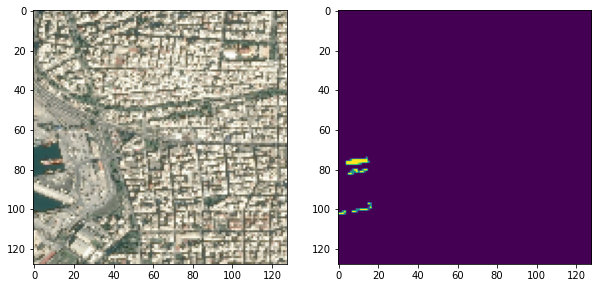

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for images, labels in validation.take(1):
    images = images[0]
    labels = labels[0]
    ax[0] = ax[0].imshow(images)
    ax[1] = ax[1].imshow(labels)

## Model Training

In [66]:
from src.models.u_net import UNet_keras
seg_model = UNet_keras(edge_crop=EDGE_CROP, img_shape=IMG_SHAPE)

In [67]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,BinaryCrossentropy 

#loss function
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [74]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="./saved_models/{}_weights.best.ctph".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=10, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=30) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, reduceLROnPlat, early]

step_count = min(MAX_TRAIN_STEPS, train_df_balanced.shape[0]//BATCH_SIZE)
loss_history = [seg_model.fit(dataset, 
                             epochs=NB_EPOCHS, 
                             validation_data=validation,
                             callbacks=callbacks_list,
                              verbose=1,
                            workers=1 # the generator is not very thread safe
                                       )]

80/94 [========================>.....] - ETA: 2:54 - loss: -0.0020 - dice_coef: 0.0026 - binary_accuracy: 0.9979 - true_positive_rate: 0.006 - ETA: 2:19 - loss: -0.0021 - dice_coef: 0.0026 - binary_accuracy: 0.9977 - true_positive_rate: 0.003 - ETA: 2:19 - loss: -0.0031 - dice_coef: 0.0036 - binary_accuracy: 0.9972 - true_positive_rate: 0.002 - ETA: 2:23 - loss: -0.0055 - dice_coef: 0.0060 - binary_accuracy: 0.9957 - true_positive_rate: 0.002 - ETA: 2:18 - loss: -0.0068 - dice_coef: 0.0073 - binary_accuracy: 0.9950 - true_positive_rate: 0.001 - ETA: 2:16 - loss: -0.0071 - dice_coef: 0.0076 - binary_accuracy: 0.9949 - true_positive_rate: 0.001 - ETA: 2:18 - loss: -0.0096 - dice_coef: 0.0101 - binary_accuracy: 0.9932 - true_positive_rate: 0.001 - ETA: 2:14 - loss: -0.0091 - dice_coef: 0.0096 - binary_accuracy: 0.9935 - true_positive_rate: 0.001 - ETA: 2:12 - loss: -0.0083 - dice_coef: 0.0088 - binary_accuracy: 0.9941 - true_positive_rate: 0.001 - ETA: 2:10 - loss: -0.0089 - dice_coef: 0.

In [112]:
import pickle

timestamp = time.strftime("%Y%m%d-%H%M%S")


export_dir = './saved_models/segm_full_{}_{}'.format(N_SAMPLE, timestamp)
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(seg_model, export_dir)


# in two lines of code
with open(f"./saved_models/segm_full_{N_SAMPLE}_{timestamp}/loss.pickle", "wb") as f:
    print('Exporting to {}/loss.pickle'.format(export_dir))
    pickle.dump(loss_history[0].history, f)


Exporting to ./saved_models/segm_full_500_20220627-151025
INFO:tensorflow:Assets written to: ./saved_models/segm_full_500_20220627-151025\assets
Exporting to ./saved_models/segm_full_500_20220627-151025/loss.pickle


In [89]:
from tensorflow import keras

#model_eval = tf.keras.model.load_model('./saved_models/segm_full_200_20220626-143859')
result = seg_model.evaluate(validation)
result

10/10 [==============================] - ETA: 0s - loss: -0.0090 - dice_coef: 0.0096 - binary_accuracy: 0.7835 - true_positive_rate: 0.381 - ETA: 0s - loss: -0.0096 - dice_coef: 0.0102 - binary_accuracy: 0.7607 - true_positive_rate: 0.360 - ETA: 0s - loss: -0.0196 - dice_coef: 0.0201 - binary_accuracy: 0.7614 - true_positive_rate: 0.420 - 0s 20ms/step - loss: -0.0203 - dice_coef: 0.0202 - binary_accuracy: 0.7630 - true_positive_rate: 0.4082


[-0.020265566185116768,
 0.020153343677520752,
 0.7629732489585876,
 0.4082159101963043]

In [97]:
import pickle
with open(f"./saved_models/segm_full_200_20220626-143859/loss.pickle", 'rb') as f:
    loss_record = pickle.load(f)

## Model Evaluation

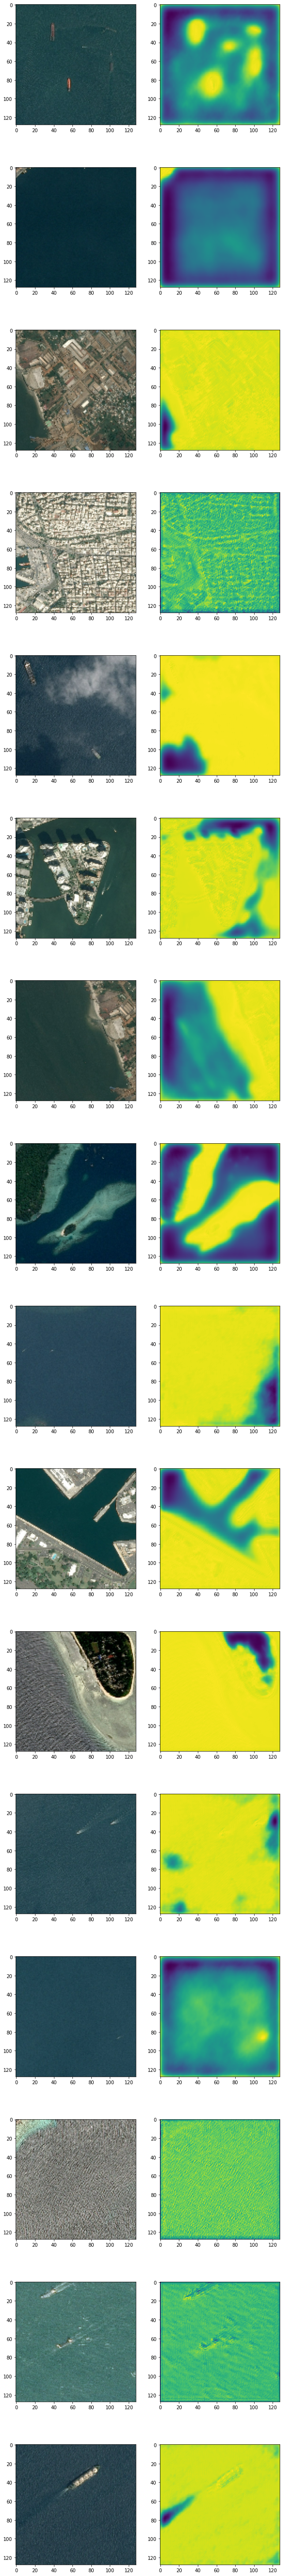

In [94]:
fig, axs = plt.subplots(BATCH_SIZE, 2, figsize=(10, 100))

preview = validation

for images, labels in preview.take(1):
    for i in range(BATCH_SIZE):
        ax = axs[i]
        image = images[i]
        label = labels[i]
        ax[0] = ax[0].imshow(image)
        ax[1] = ax[1].imshow(seg_model.predict(preview.take(1))[i])

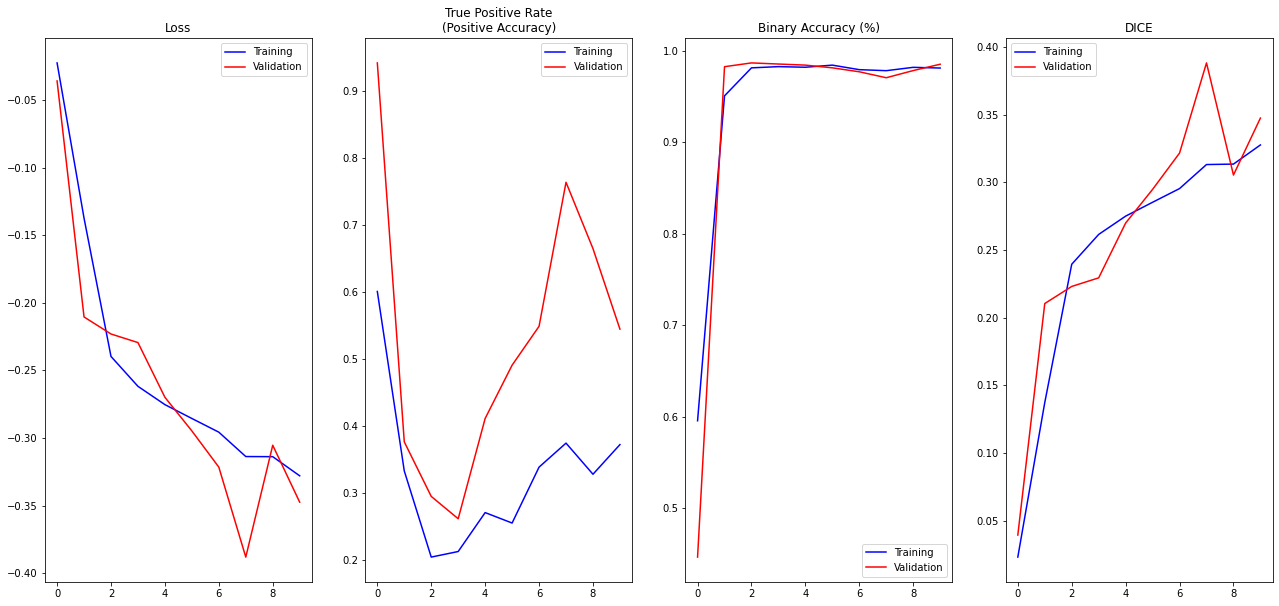

In [98]:
def show_loss(loss_record):
    epich = [i for i in range(len(loss_record['loss']))]
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([loss_record['loss']]),
                 'b-',
                 epich, np.concatenate(
            [loss_record['val_loss']]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [loss_record['true_positive_rate']]), 'b-',
                     epich, np.concatenate(
            [loss_record['val_true_positive_rate']]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [loss_record['binary_accuracy']]), 'b-',
                     epich, np.concatenate(
            [loss_record['val_binary_accuracy']]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [loss_record['dice_coef']]), 'b-',
                     epich, np.concatenate(
            [loss_record['val_dice_coef']]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_record)